# Notebook for interactive testing for CLIP

In [10]:
import gc
import os
from itertools import islice
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:64"
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import pipeline, CLIPModel, CLIPProcessor
from tqdm import tqdm
# plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
LOADER_PATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Cuda Availability:{torch.cuda.is_available()} Training on {device}")

Cuda Availability:True Training on cuda


In [2]:

class Cfg:
    model_id: str = "openai/clip-vit-base-patch32"
    batch_size: int = 32
    epochs: int = 40
    seed:   int = 42

    # -------- Optim & Loss ----------
    lr_head: float = 1e-3      # 线性头
    wd_head: float = 1e-4
    lr_lora: float = 1e-3      # LoRA 注入层
    wd_lora: float = 1e-2
    lambda_text: float = 0.3   # 文本对齐辅助损失权重
    
    early_stopping: bool = True
    early_stop_patience = 3
    early_stop_minimum_improvement:float = 0.05
    

    # -------- LoRA ----------
    lora_rank: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.0
    lora_target: tuple = ("q_proj","k_proj","v_proj","out_proj")  # 只对注意力投影层做LoRA
    # 也可扩展到 MLP 内部 proj，但注意稳定性

    amp: bool = True

cfg = Cfg()

PREPROCESS_DATA_ROOT = "data/preprocessed"
torch.manual_seed(cfg.seed)
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor  = CLIPProcessor.from_pretrained(model_id)

C:\Users\Yukun\anaconda3\envs\sc4001\Lib\site-packages\torch\nn\modules\module.py:1357: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
# ---------- 2. Load Dataset ----------
def collate_pil(batch):
    # batch: List[ (PIL.Image.Image, int) ]
    images, labels = zip(*batch)           # images: tuple of PIL, labels: tuple of int
    return list(images), torch.tensor(labels)  # 让 processor 接收 list[PIL]，labels 变成 LongTensor

def preprocess_dataset(split="train",data_root='data',outputdir="data/preprocessed",batchsize=cfg.batch_size,fp16=False):
    os.makedirs(outputdir,exist_ok=True)
    dataset = datasets.Flowers102(root=data_root, split=split, download=True)
    classes = dataset.classes
    loader = DataLoader(dataset, batch_size=batchsize, shuffle= True if split=="train" else False, num_workers=0,collate_fn=collate_pil)
    
    # Allocate RAM
    N = len(dataset)
    C, H, W = 3, 224, 224
    pixels = torch.empty((N,C,H,W), dtype=torch.float32 if not fp16 else torch.float16)
    labels = torch.empty(N, dtype=torch.long)
    
    print(f"Preprocessing {split} data...")
    
    index = 0
    with torch.no_grad():
        for images, y in tqdm(loader,desc=f"Preprocessing {split}"):
            pix = processor(images=images,return_tensors="pt")['pixel_values']
            if fp16:
                pix = pix.half()
            b = pix.size(0) # patch size
            pixels[index:index+b] = pix
            labels[index:index+b] = y
            index += b
    
    
    out_path = os.path.join(outputdir, f"{split}.pt")
    torch.save({"pixel_values": pixels, "labels": labels, "fp16": fp16,"classes":classes}, out_path)
    print(f"Saved → {out_path} (pixels: {pixels.shape}, dtype={pixels.dtype})")
    
    print("Performing Garbage Cleaning...")
    del pixels, labels
    torch.cuda.empty_cache()
    gc.collect()
    
    # for notebook
    %reset_selective -f pixels
    %reset_selective -f labels

class CacheDataset:
    def __init__(self, split="train", root="data/preprocessed"):
        path = os.path.join(root, f"{split}.pt")
        obj = torch.load(path, map_location="cpu")
        self.pixel_values = obj["pixel_values"]
        self.labels = obj["labels"]
        self.fp16 = bool(obj.get("fp16", False))
        self.classes = obj['classes']
        
    def __len__(self):
        return self.labels.numel()
    
    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]
    
    
# Preprocess and save dataset                
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "train.pt")):    
    preprocess_dataset(split="train",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "val.pt")):  
    preprocess_dataset(split="val",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "test.pt")):  
    preprocess_dataset(split="test",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)




#Load dataset
train_set = CacheDataset(split="train")
val_set = CacheDataset(split="val")
test_set = CacheDataset(split="test")

classname = val_set.classes
classname




['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [4]:
# ---------- 3. DataLoader ----------
# ---------- Process of images is put on epoch loops

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True,
    num_workers=0, pin_memory=True
    #workers should be 4, but got problems in notebook
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

---
## Model Setting and Training

In [5]:
# Word Prompt Embedding
import torch
from tqdm import tqdm

promptTemplate = {
    "A photo of {}.",
    "A photo of flower {}.",
    "Botanic picture of {}",
    "A example picture of type {}"
}
# Use more templates to reduce sensitivity to other contexts

@torch.no_grad()
def build_text_embeddings(names):
    embs = []
    for name in tqdm(names, desc="TextEmbed"):
        prompts = [t.format(name.replace("_"," ")) for t in promptTemplate] # insert class names
        inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
        te = clip_model.get_text_features(**inputs)     # [T, D]
        te = te / te.norm(dim=-1, keepdim=True)
        embs.append(te.mean(dim=0))                     # [D]
    text = torch.stack(embs, dim=0)                     # [C, D]
    return text / text.norm(dim=-1, keepdim=True)

text_embs = build_text_embeddings(classname)          # [102, D], 固定不训练



TextEmbed: 100%|██████████| 102/102 [00:01<00:00, 91.16it/s]


----
## Building CLIP model with LoRA and word embedding.

Have to implement a LoRA linear layer ourselves.

In [6]:
# LoRA Injection (Trains LoRA matries only)
import torch, torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPVisionModel

# y = w0 + x*(BA)*alpha/rank
# Shape of A: din by rank / Shape of B: rank by dout
class LoRALinearLayer(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):

        super().__init__()
        self.base = base # linear layer frozen for training LoRA parameters
        self.r = r
        self.scaling = alpha / r
        dev = base.weight.device
        dt  = base.weight.dtype

        

        if r > 0:
            self.lora_A = nn.Linear(base.in_features, r, bias=False).to(dev, dtype=dt)
            self.lora_B = nn.Linear(r, base.out_features, bias=False).to(dev, dtype=dt)
            self.dropout = nn.Dropout(dropout)
            nn.init.kaiming_uniform_(self.lora_A.weight,a=5**0.5)
            nn.init.zeros_(self.lora_B.weight) # set B to 0, avoid any bias introduced.
        else:
            self.lora_A = None
            self.lora_B = None
            self.dropout = nn.Identity()

            #Frozen
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        if self.r > 0:
            return self.base(x) + self.dropout(self.lora_B(self.lora_A(x))) * self.scaling
        else:
            return self.base(x)


# LoRA Injection with warped LoRA layer shown above.

def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        # injection to clip/transformer attention layer: q_proj/k_proj/v_proj/out_proj
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    # Freeze the parameters
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  # ViT-B/32 = 512
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    # 2 parameter groups: LoRA and linear head
    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler


In [7]:
head, optimizer, scaler = build_head_and_optim(clip_model)
ce = torch.nn.CrossEntropyLoss()

def get_image_feats(images):
    # images are actual tensor now
    # assume it's preprocessed
    if isinstance(images, torch.Tensor):
        pixel_values = images.to(device, dtype=torch.float16 if (device=="cuda" and cfg.amp) else torch.float32)
    else:
        inputs = processor(images=images, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]
        
    feats = clip_model.get_image_features(pixel_values=pixel_values)           # [B, D]
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def supervised_logits(feats):
    return head(feats)                                        # [B, 102]

def text_logits(feats):
    # perform cosine similarity with text embedding.
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()


----
## Main Training Epoch

In [12]:
from collections import defaultdict
class EarlyStopper:
    def __init__(self):
        self.counter = 0
        self.last_loss = 0
        self.patience = cfg.early_stop_patience
        self.enable = cfg.early_stopping
        self.delta = cfg.early_stop_minimum_improvement
    def report(self,loss):
        if self.last_loss - loss < self.delta:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss
    
    def stop_flag(self):
        return self.enable and (self.counter >= self.patience)
        
def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    
    correct_per_label = defaultdict(int)
    total_per_label = defaultdict(int)
    
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)                   # [B, D]

            logits_cls = supervised_logits(feats) # logits of classification score from linear layer head
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) # logits of text embedding trained in transformer
            loss_txt = ce(logits_txt, labels)
            # Alignment between text and img.

            loss = loss_cls + cfg.lambda_text * loss_txt # weighted
            

        if train:
            # backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


        #Stats
        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)
        
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()
        # Label_wise
        for label, pred in zip(labels, pred_cls):
            label = label.item()
            total_per_label[label] += 1
            if pred.item() == label:
                correct_per_label[label] += 1
    
    
    
    label_acc = {lbl: correct_per_label[lbl] / total_per_label[lbl]
                 for lbl in total_per_label.keys()}
    
        
    loss_avg = loss_sum / total
    
    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,   # 线性头准确率
    "acc_txt": correct_txt/total,# 文本读出准确率（zero-shot 风格）
    "label_acc": label_acc
}

def test_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    correct_per_label = defaultdict(int)
    total_per_label = defaultdict(int)

    # 收集所有预测和真实标签以计算混淆矩阵
    all_labels = []
    all_preds = []

    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)
            logits_cls = supervised_logits(feats)
            loss_cls = ce(logits_cls, labels)
            logits_txt = text_logits(feats)
            loss_txt = ce(logits_txt, labels)
            loss = loss_cls + cfg.lambda_text * loss_txt

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (pred_cls == labels).sum().item()
        correct_txt += (pred_txt == labels).sum().item()

        # 记录每个类别的预测情况
        for label, pred in zip(labels, pred_cls):
            label = label.item()
            total_per_label[label] += 1
            if pred.item() == label:
                correct_per_label[label] += 1

        # 收集整体预测结果
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred_cls.cpu().numpy())

    # === Label-wise accuracy ===
    label_acc = {
        lbl: correct_per_label[lbl] / total_per_label[lbl]
        for lbl in total_per_label.keys()
    }

    # === Confusion matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

    loss_avg = loss_sum / total

    return {
        "loss": loss_avg,
        "acc_cls": correct_cls / total,
        "acc_txt": correct_txt / total,
        "label_acc": label_acc,
        "confusion_matrix": cm,  # 如果你想进一步分析
    }

In [9]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
epoch_stat = []
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"[{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")

    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } # Detach the parameters from autograd (keeps weights only)
    earlystop.report(val['loss'])
    epoch_stat.append([ep,training['loss'],val['loss'],training['acc_cls'],val['acc_cls']])
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")
        break


if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = test_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(epoch_stat).to_csv('vanilla.csv')

Eval: 100%|██████████| 32/32 [00:01<00:00, 17.74it/s]


[1/40] Train: loss=4.9711 acc_cls=0.0725 acc_txt=0.7020 | Val:   loss=4.7835 acc_cls=0.2137 acc_txt=0.7833


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.81it/s]


[2/40] Train: loss=4.5433 acc_cls=0.5108 acc_txt=0.9353 | Val:   loss=4.5435 acc_cls=0.7176 acc_txt=0.8529


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.86it/s]


[3/40] Train: loss=4.2636 acc_cls=0.8686 acc_txt=0.9892 | Val:   loss=4.2947 acc_cls=0.8441 acc_txt=0.8716


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.84it/s]


[4/40] Train: loss=3.9873 acc_cls=0.9510 acc_txt=0.9922 | Val:   loss=4.0432 acc_cls=0.8892 acc_txt=0.8706


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.87it/s]


[5/40] Train: loss=3.7070 acc_cls=0.9853 acc_txt=1.0000 | Val:   loss=3.8170 acc_cls=0.9029 acc_txt=0.8755


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.77it/s]


[6/40] Train: loss=3.4379 acc_cls=0.9922 acc_txt=0.9990 | Val:   loss=3.6206 acc_cls=0.9029 acc_txt=0.8618


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.86it/s]


[7/40] Train: loss=3.1721 acc_cls=0.9941 acc_txt=1.0000 | Val:   loss=3.3823 acc_cls=0.9265 acc_txt=0.8667


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.85it/s]


[8/40] Train: loss=2.9130 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=3.2168 acc_cls=0.9206 acc_txt=0.8510


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.94it/s]


[9/40] Train: loss=2.6637 acc_cls=0.9990 acc_txt=1.0000 | Val:   loss=3.0334 acc_cls=0.9225 acc_txt=0.8490


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.86it/s]


[10/40] Train: loss=2.4355 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.8389 acc_cls=0.9225 acc_txt=0.8549


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.98it/s]


[11/40] Train: loss=2.2143 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.6497 acc_cls=0.9304 acc_txt=0.8627


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.91it/s]


[12/40] Train: loss=1.9990 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.4618 acc_cls=0.9255 acc_txt=0.8618


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.94it/s]


[13/40] Train: loss=1.7907 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.2784 acc_cls=0.9373 acc_txt=0.8735


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.93it/s]


[14/40] Train: loss=1.5902 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.1328 acc_cls=0.9235 acc_txt=0.8676


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.88it/s]


[15/40] Train: loss=1.4056 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.0036 acc_cls=0.9333 acc_txt=0.8637


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.99it/s]


[16/40] Train: loss=1.2354 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.8505 acc_cls=0.9324 acc_txt=0.8725


Eval: 100%|██████████| 32/32 [00:01<00:00, 18.00it/s]


[17/40] Train: loss=1.0795 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.7071 acc_cls=0.9402 acc_txt=0.8784


Eval: 100%|██████████| 32/32 [00:01<00:00, 18.11it/s]


[18/40] Train: loss=0.9406 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6077 acc_cls=0.9412 acc_txt=0.8706


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.96it/s]


[19/40] Train: loss=0.8179 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5197 acc_cls=0.9353 acc_txt=0.8627


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.94it/s]


[20/40] Train: loss=0.7116 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4141 acc_cls=0.9314 acc_txt=0.8647


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.99it/s]


[21/40] Train: loss=0.6174 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3335 acc_cls=0.9363 acc_txt=0.8735


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.98it/s]


[22/40] Train: loss=0.5367 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2504 acc_cls=0.9392 acc_txt=0.8784


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.97it/s]


[23/40] Train: loss=0.4684 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2032 acc_cls=0.9343 acc_txt=0.8706


Eval: 100%|██████████| 32/32 [00:01<00:00, 18.04it/s]


[24/40] Train: loss=0.4112 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1468 acc_cls=0.9333 acc_txt=0.8725


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.85it/s]


[25/40] Train: loss=0.3626 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1153 acc_cls=0.9235 acc_txt=0.8725


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.96it/s]


[26/40] Train: loss=0.3226 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.0746 acc_cls=0.9294 acc_txt=0.8765


Eval: 100%|██████████| 32/32 [00:01<00:00, 17.98it/s]


[27/40] Train: loss=0.2875 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.0365 acc_cls=0.9255 acc_txt=0.8716
Early stop triggered...Exiting on epoch 27


Eval: 100%|██████████| 193/193 [00:10<00:00, 17.92it/s]


NameError: name 'confusion_matrix' is not defined

Eval: 100%|██████████| 193/193 [00:11<00:00, 17.54it/s]


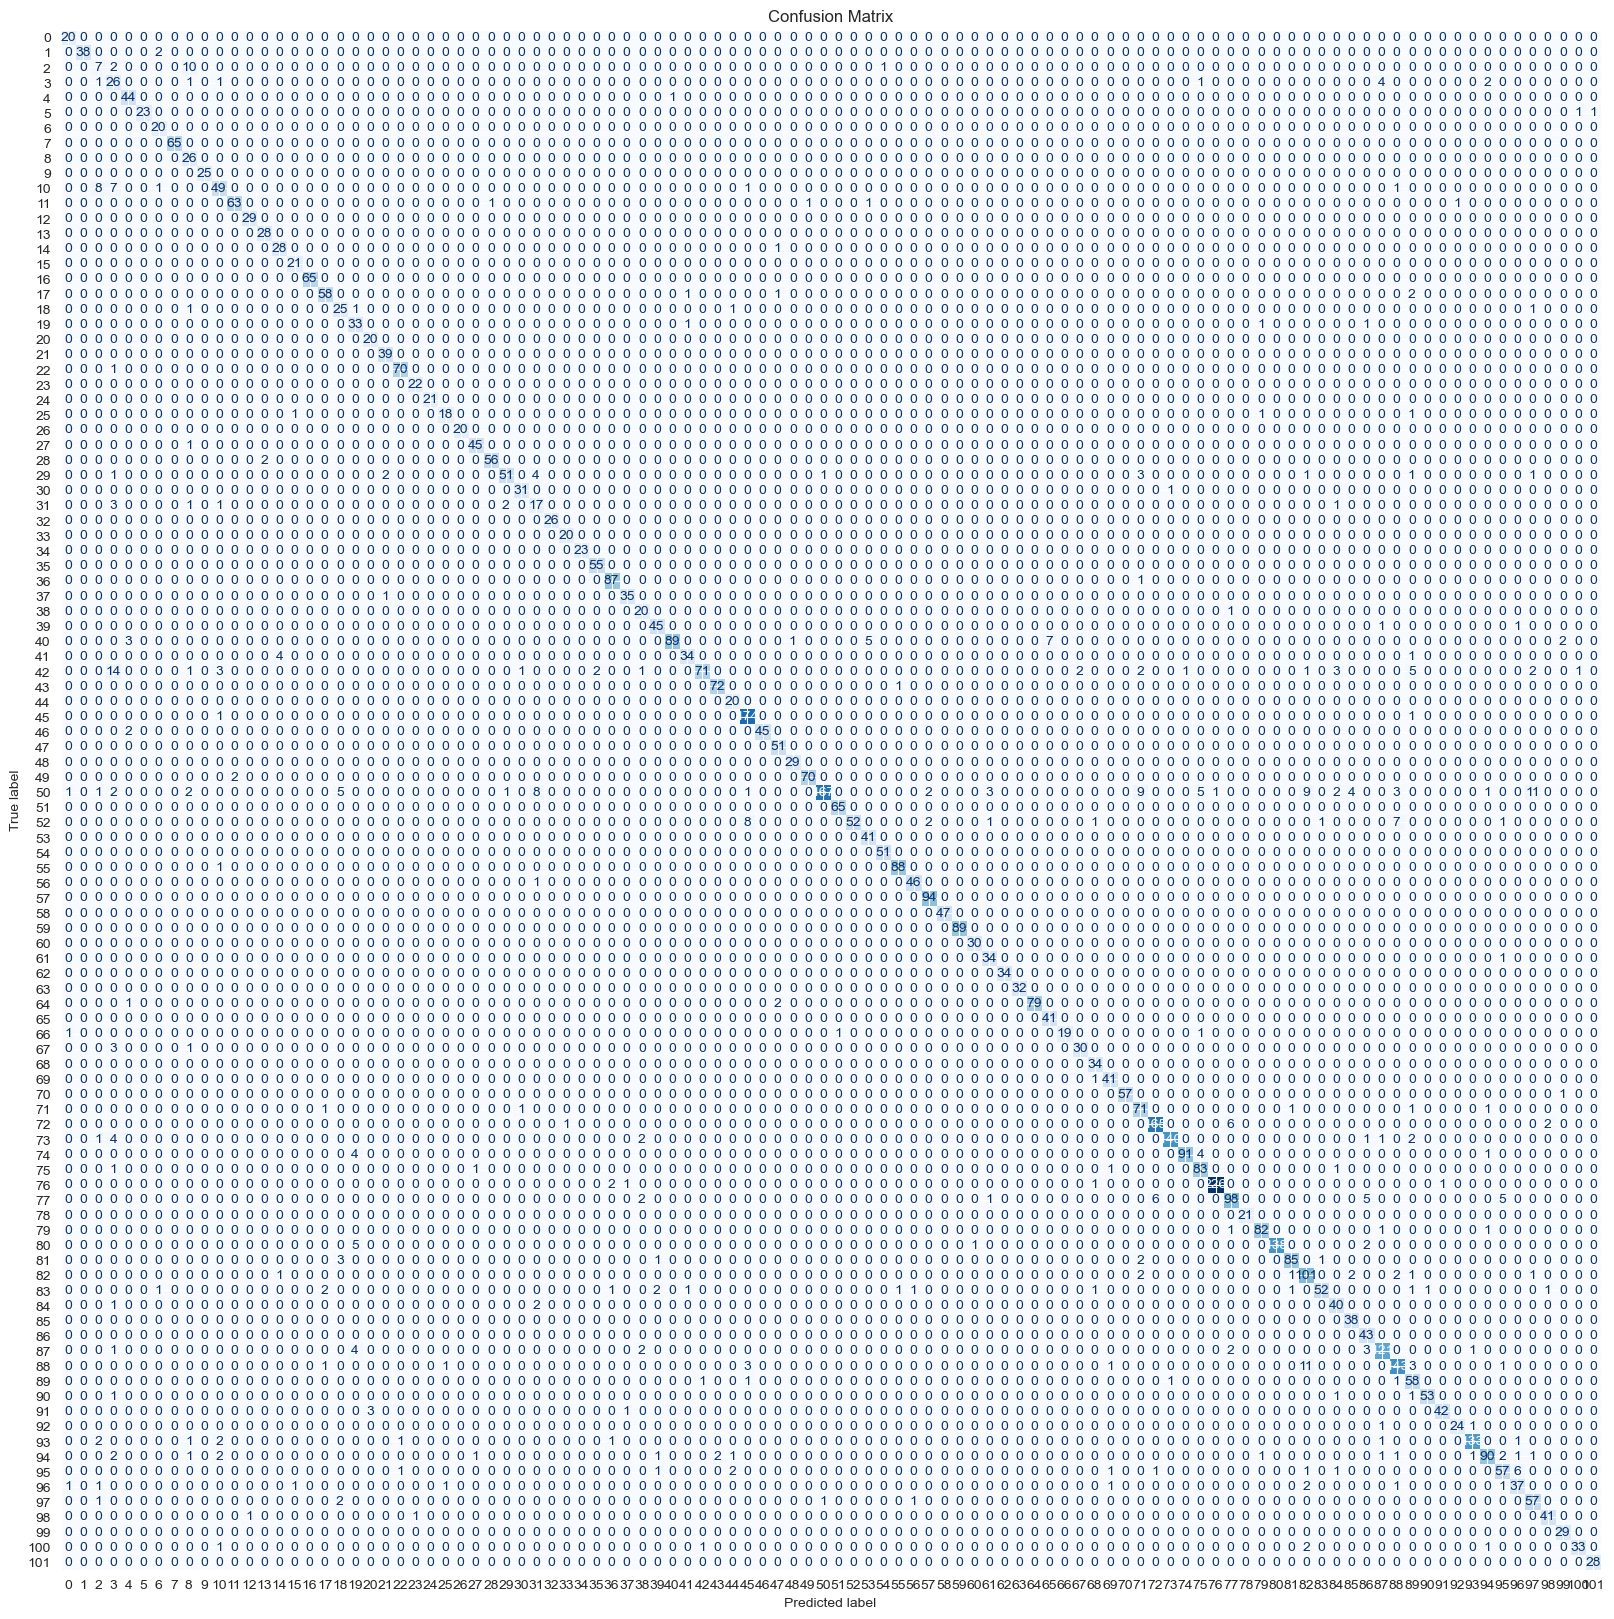

Test: loss=1.6504  acc_cls=0.9205  acc_txt=0.8522


In [13]:
te = test_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(epoch_stat).to_csv('vanilla.csv')

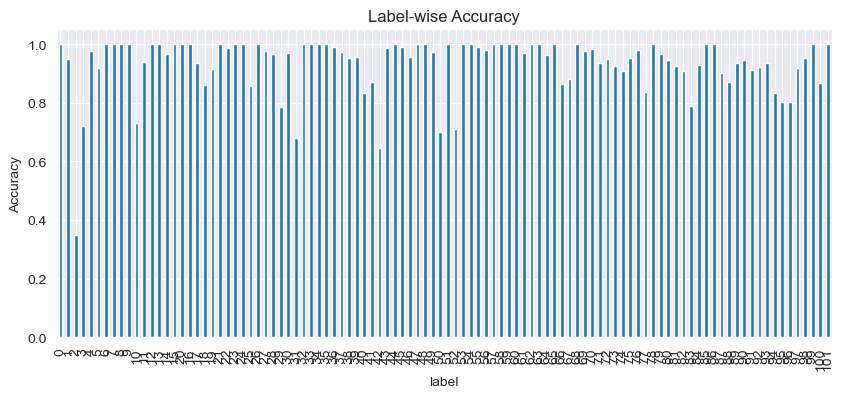

In [14]:
import pandas as pd

df = pd.DataFrame(list(te["label_acc"].items()), columns=["label", "accuracy"])
df.plot.bar(x="label", y="accuracy", figsize=(10,4), legend=False)
plt.title("Label-wise Accuracy")
plt.ylabel("Accuracy")
plt.show()

## Save trained model
### Save head layer and LoRA layers only

In [2]:
# Save Trained weights, as only head layer is trained
def save_light_model(path,clip_model,head):
    # sort out LoRA layers
    lora_states = {k:v for k,v in clip_model.state_dict().items() if "lora_" in k}
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "head_state_dict": head.state_dict(),
        "lora_states": lora_states,
    }
    torch.save(checkpoint,path)
    print(f"Light weight model (only contains head and LoRA) saved to {path}")


    # Return clip_lora, head
def load_light_simple(path, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    missing, unexpected = clip_model.load_state_dict(checkpoint["lora_states"], strict=False) # set to false allow partial loading
    print(missing, unexpected)

    feat_dim = clip_model.config.projection_dim
    head = nn.Linear(feat_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"[light] loaded ← {path}")
    return clip_model, head



from pathlib import Path



# Transformer Style Saving

def save_full_dir(output_dir, clip_model, head):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)
    clip_model.save_pretrained(output)           # 保存到目录（含 LoRA 参数）
    torch.save({"num_classes": head.out_features,
                "state_dict": head.state_dict()}, output/"head.pt")
    print(f"[full-dir] saved → {output}")

def load_full_dir(output_dir, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    from transformers import CLIPModel
    output = Path(output_dir)

    clip_model = CLIPModel.from_pretrained(output).to(device)  # Load from folder
    # 如你的保存目录包含了 LoRA 权重（因为它在 state_dict 里），这一步就不用再注入；
    # 如果恢复后发现没有 LoRA 结构，可与上面相同：先注入再 load。

    head_ckpt = torch.load(output/"head.pt", map_location=device)
    import torch.nn as nn
    head = nn.Linear(clip_model.config.projection_dim, head_ckpt["num_classes"]).to(device)
    head.load_state_dict(head_ckpt["state_dict"])
    print(f"[full-dir] loaded ← {output}")
    return clip_model, head







# Single File
def save_full_model(path,clip_model,head):
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "clip_state_dict": clip_model.state_dict(),
        "head_state_dict": head.state_dict(),
    }
    torch.save(checkpoint,path)
    print(f"Full  model  saved to {path}")

def load_full_model(path,device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)

    print(checkpoint["clip_name"])
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    clip_model.load_state_dict(checkpoint["clip_state_dict"], strict=True) # This time true cause loading full model

    head = nn.Linear(clip_model.config.projection_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"Full  model  loaded from {path}")
    return clip_model, head


NameError: name 'device' is not defined

In [ ]:
# Actual Saving Code
os.makedirs("model",exist_ok=True)
save_light_model("model/clip_weights.pt", clip_model, head)

In [ ]:
# Try loading one
clip_model, head = load_light_simple("model/clip_weights.pt")

from itertools import islice
clip_model.eval()
head.eval()
processor = CLIPProcessor.from_pretrained(getattr(clip_model, "name_or_path", "openai/clip-vit-base-patch32"))

def collate_pil(batch):
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels, dtype=torch.long)

val_set  = datasets.Flowers102(root="./data", split="val",  download=True)
test_set = datasets.Flowers102(root="./data", split="test", download=True)
val_loader  = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)

@torch.no_grad()
def evaluate_first(loader):
    total, correct = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)          # [B, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = head(feats)                                     # [B, C]
        pred = logits.argmax(dim=-1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return correct / total


val_acc  = evaluate_first(val_loader)
test_acc = evaluate_first(test_loader)
print(f"Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")

In [ ]:
# This block saves full model

# save_full_model("model/full_model.pt", clip_model, head)
# clip_model, head = load_full_model("model/full_model.pt")

----
## Fine-Tuning of CLIP: Visual Prompt Tuning

We insert a learnable prompt before encoder of transformer, along with the images.

In [12]:
# Config
VISUAL_PROMPT_SIZE = 16

class VPTShallowClip(nn.Module):
    def __init__(self, clip_model: CLIPModel, init_std: float = 0.02, freeze_backbone: bool = True):
        super().__init__()
        self.clip = clip_model
        vm = self.clip.vision_model
        D = vm.config.hidden_size # Hidden size of embedding
        m = VISUAL_PROMPT_SIZE
        self.prompt =   nn.Parameter(torch.randn(m, D) * init_std)
        self.prompt_pos = nn.Parameter(torch.zeros(1,m, D)) # Positional Encoding, each one is different thus need B different ones.
        
        if freeze_backbone:
            for p in self.clip.vision_model.parameters():
                p.requires_grad = False
            for p in self.clip.visual_projection.parameters():
                p.requires_grad = False
        
        
    @torch.no_grad()
    def embed_with_pos(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # reuse
        return self.clip.vision_model.embeddings(pixel_values)
    
    def _encode_with_prompts(self, x: torch.Tensor) -> torch.Tensor:
    # CLS+ img patch = [B, 1+N, D]
    # we add prompt and prompt_pos into the vector before the actual image.
    
        vm = self.clip.vision_model
        B = x.size(0)
        cls, patches = x[:,:1, :], x[:,1:,:]
        p = self.prompt + self.prompt_pos # positional embedding
        p = p.expand(B, -1, -1)
    
        x0 = torch.cat([cls, p, patches], dim=1)
        
        # send to model for embedding
        h = vm.pre_layrnorm(x0)
        enc_out = vm.encoder(inputs_embeds=h)
        last = enc_out.last_hidden_state                   # [B,1+m+N,D]
        last = vm.post_layernorm(last)
        
        return last
    
    def get_image_features(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # align with CLIPmodel.get_image_features to ensure code reusable
        pixel_values = pixel_values.to(next(self.parameters()).device, dtype=next(self.parameters()).dtype)
        
        x = self.embed_with_pos(pixel_values) # [B,1+N,M]
        
        last = self._encode_with_prompts(x)
        
        pooled = last[:,0,:] # get cls [B,D]
        
        feats = self.clip.visual_projection(pooled)       # [B, projection_dim]
        return feats
        
def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        # injection to clip/transformer attention layer: q_proj/k_proj/v_proj/out_proj
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    # Freeze the parameters
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim_vpt(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  # ViT-B/32 = 512
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    # 2 parameter groups: LoRA and linear head
    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
            {"params": [vpt.prompt, vpt.prompt_pos], "lr": 5e-3, "weight_decay": 0.0},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler

In [13]:
# Re init

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

vpt = VPTShallowClip(clip_model, init_std=0.02, freeze_backbone=True).to(device)

head, optimizer, scaler = build_head_and_optim_vpt(clip_model)
ce = torch.nn.CrossEntropyLoss()


def supervised_logits(feats):
    return head(feats)                                        # [B, 102]

def text_logits(feats):
    # perform cosine similarity with text embedding.
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()

def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = vpt.get_image_features(pixel_values=images)                # [B, D]
            feats  = feats / feats.norm(dim=-1, keepdim=True)
            logits_cls = supervised_logits(feats) # logits of classification score from linear layer head
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) # logits of text embedding trained in transformer
            loss_txt = ce(logits_txt, labels)
            # Alignment between text and img.

            loss = loss_cls + cfg.lambda_text * loss_txt # weighted


        if train:
            # backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


        #Stats

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()
        
    loss_avg = loss_sum / total
    
    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,   # 线性头准确率
    "acc_txt": correct_txt/total,   # 文本读出准确率（zero-shot 风格）
}



In [15]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
vpt_stats = []
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"VPT tuned Model on epoch [{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")


    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } # Detach the parameters from autograd (keeps weights only)
    earlystop.report(val['loss'])
    vpt_stats.append([ep,training['loss'],val['loss'],training['acc_cls'],val['acc_cls']])
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")
        break

if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = run_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(vpt_stats).to_csv('vpt.csv')

NameError: name 'EarlyStopper' is not defined

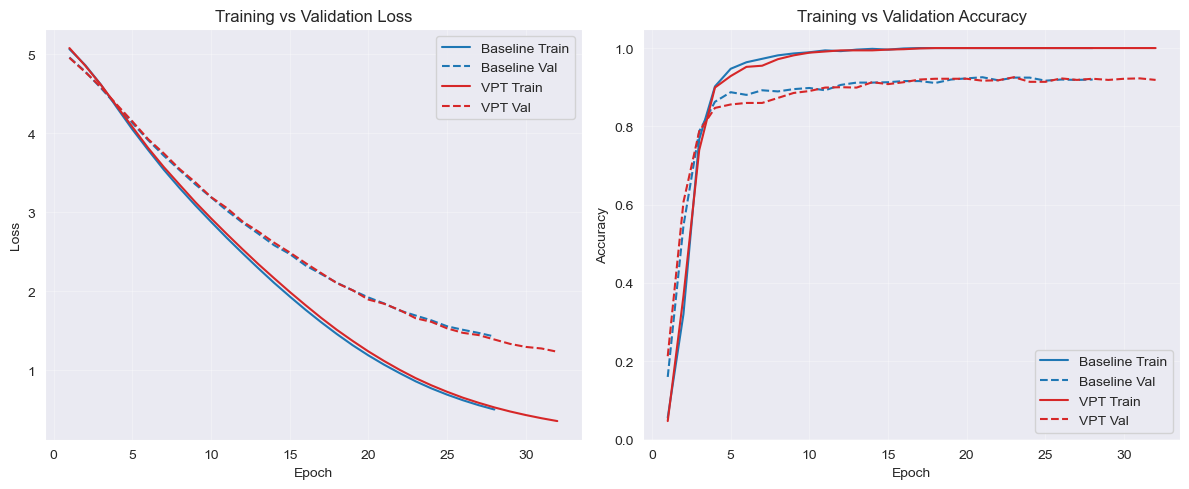

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 假设两个列表结构相同：
# [epoch, train_loss, val_loss, train_acc, val_acc] .columns=["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_base = pd.read_csv('vanilla.csv').drop(columns=['Unnamed: 0'])
df_base.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_vpt = pd.read_csv('vpt.csv').drop(columns=['Unnamed: 0'])
df_vpt.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]

# 设置绘图风格
plt.figure(figsize=(12,5))

# --- 1️⃣ Loss 对比 ---
plt.subplot(1,2,1)
sns.lineplot(data=df_base, x="epoch", y="train_loss", label="Baseline Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_loss",   label="Baseline Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_vpt,  x="epoch", y="train_loss", label="VPT Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_vpt,  x="epoch", y="val_loss",   label="VPT Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

# --- 2️⃣ Accuracy 对比 ---
plt.subplot(1,2,2)
sns.lineplot(data=df_base, x="epoch", y="train_acc", label="Baseline Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_acc",   label="Baseline Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_vpt,  x="epoch", y="train_acc", label="VPT Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_vpt,  x="epoch", y="val_acc",   label="VPT Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()
